In [2]:
#imports
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy as scpy
from scipy import stats
from scipy import ndimage
from skimage.transform import resize
import dionysus as d
import os
import csv
import pandas as pd
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from statannot import add_stat_annotation

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io

import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['font.sans-serif']="Arial"
matplotlib.rcParams['font.family']="sans-serif"
# matplotlib.rcParams.update({'font.size': 12})

#### Load in images and determine user inputs

In [38]:
#load images
image_loc = 'ExampleData/'

file_name = image_loc
path, dirs, files = os.walk(file_name).__next__()
len_files = len(files)-1

files = [file for file in files if 'cropped' in file and 'figure' not in file]

In [52]:
print(files)

['Zoom04_UWZ-250to300_ZHue_10nm_ZStack_gray_cropped.tif']


In [40]:
# define pixel sizes
pix_sizes = np.array([0.01])

pod_feature_size = 0.3 #um
site_feature_size = 1.5 #um


#### Run images through persistent homology pipeline to discover podosome and phagocytosis site locations
1. Perform persistent homology (see helper_functions.py) to find significant critical points within images.
2. Perform processing of the candidate significantly persistent features. For this step, several things are done (check out cluster_refine_pods_and_sites() in helper_functions.py). Essentially, make sure that we only keep podosomes associated with a well-defined site, that these sites have 3 or more podosomes, and that the site centers are centered based on their associated podosomes.

In [42]:
image_stacks = []
all_clusters = []
all_centers = []

for i,file in enumerate(files):
    image_stack = io.imread(image_loc+file,plugin="tifffile") #Image.open('002_AT_Act.tif')
    image_stacks.append([image_stack])
    image_mean = np.mean(image_stack,axis=0)

    pix_size = pix_sizes[i]
    len_micron = int(1/pix_size)
    pod_filt = int(pod_feature_size*len_micron)
    site_filt = int(site_feature_size*len_micron)

    pods, sites = find_pod_and_sites_ph(image_mean,pod_filt,site_filt,plot_bool=False,plot_pers=False,save_file = '')
    clusters,centers,radii = cluster_refine_pods_and_sites(pods,sites,image_mean,pix_size,plot_bool=False,save_file = '',upper_lim=2.5,lower_lim=1.5)
    all_clusters.append(clusters)
    all_centers.append(centers)

#### Save and/or load results. Visualize results.

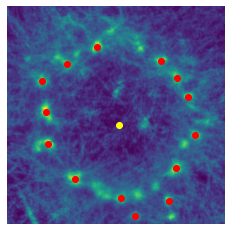

In [43]:
fig = plt.plot(figsize=(3,3))
axs = plt.gca()
i = 0

plt.imshow(np.mean(image_stacks[i],axis=1)[0])
plt.scatter(all_clusters[i].T[0],all_clusters[i].T[1],color='red')
plt.scatter(all_centers[i].T[0],all_centers[i].T[1],color='yellow')
plt.axis('off')
plt.show()

#### Perform radial averaging at each podosomes

In [44]:
min_stack_num = np.min([len(image[0]) for image in image_stacks])

z_height = 10 #nm
heights = np.arange(0,z_height*(min_stack_num),10)

all_rad_scans = []
all_x_ums = []

for i,image_stack in enumerate(image_stacks):
    rad_scans = []
    # plt.figure()
    for image in image_stack[0][:min_stack_num,:,:]:

        actin=image
        
        clusters = all_clusters[i]
        podosome_centers = np.array([list(point) for cluster in clusters for point in cluster])
        cxs = podosome_centers.T[0]
        cys = podosome_centers.T[1]
        
        pix_size = pix_sizes[i]

        rad_profs_act, x_ums = radial_averaging_from_pods(cxs,cys,actin,pix_size,1.1)

        rad_scans.append(rad_profs_act)
        
        
    all_rad_scans.append(rad_scans)
    all_x_ums.append(x_ums)
    

#### Process radial averaging scans
1. Want to have all of our data to use the same discretization
2. Interpolate any data with higher resolution to the the coarsest discretization
3. Also only keep from 0 to .6 micron

In [45]:
# Want to have all of our data to use the same discretization
# Interpolate any data that without the coarsest discretization to the coarsest
# Also only keep from 0 to .6 micron

max_r = 600#nm
for i, pix_size in enumerate(pix_sizes):
    x = all_x_ums[i]
    ys = all_rad_scans[i]
    fs = [scpy.interpolate.interp1d(x, y) for y in ys]

    xnew = np.arange(0,max_r/1000+0.01,0.01)
    ysnew = [f(xnew) for f in fs]
    all_x_ums[i] = xnew
    all_rad_scans[i] = ysnew

        

## Plot each individual podosome's radial heatmap

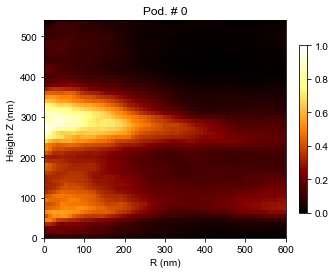

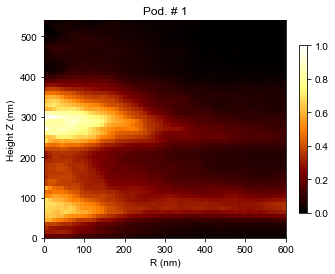

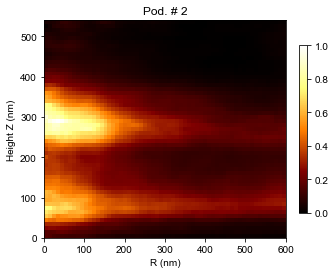

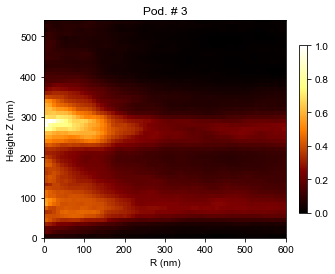

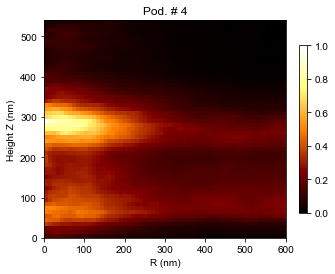

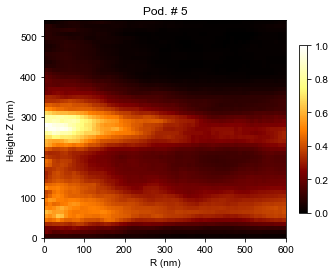

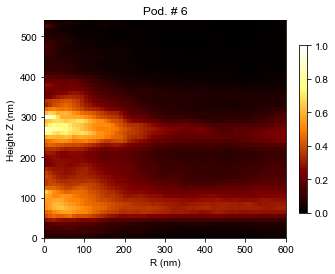

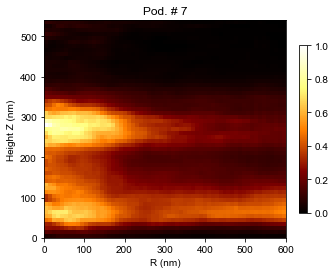

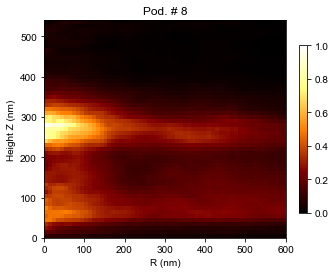

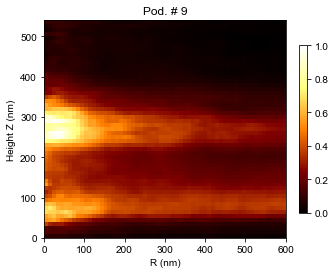

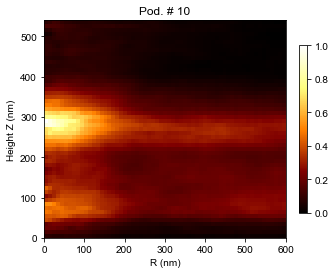

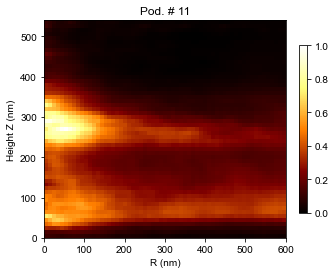

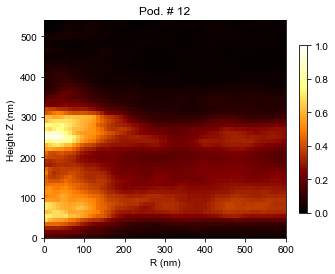

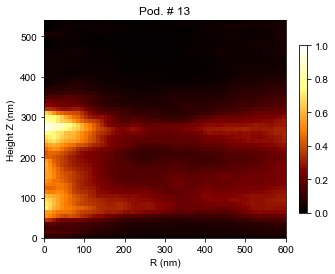

In [46]:
stack_all_rad_scans = np.hstack(all_rad_scans)


for i in range(np.shape(stack_all_rad_scans)[1]):
    average_radial = np.array(stack_all_rad_scans)[:,i,:] #np.mean(np.hstack(all_rad_scans),axis=1)
#     average_radial = scpy.ndimage.gaussian_filter(average_radial_mirrored ,1)
    average_radial = max_min_scaled(average_radial)

    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(0, 10*(len(average_radial)-1), len(average_radial))
    X, Y = np.meshgrid(x, y)

    plt.figure()
    plt.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
    plt.colorbar(fraction=0.025, pad=0.04)
#     CS = plt.contour(X,Y,average_radial_mirrored/np.max(average_radial_mirrored),levels=np.array([contour_level]), colors='limegreen', linestyles='--')
    plt.xlabel('R (nm)')
    plt.ylabel('Height Z (nm)')
    plt.title('Pod. # %i' %i)

#### Plot average within 100 nm and beyond 400 nm distributions

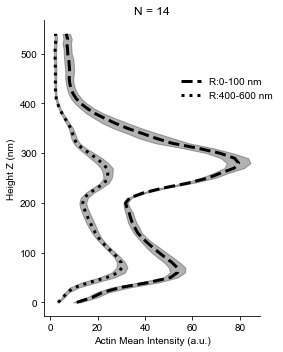

In [47]:
all_rad = np.hstack(all_rad_scans)

plt.figure(figsize=(4,5))
mean_within100 = np.mean(np.mean(all_rad.T[:11],axis=0),axis=0)
ci_within100 = 1.96*stats.sem(np.mean(all_rad.T[:11],axis=0),axis=0)
plt.plot(mean_within100,heights,'--',c='k',lw=3)
plt.fill_betweenx(heights, (mean_within100-ci_within100), \
                 (mean_within100+ci_within100), \
                 alpha=0.3,color='k') 


mean_out400 = np.mean(np.mean(all_rad.T[40:],axis=0),axis=0)
ci_out400 = 1.96*stats.sem(np.mean(all_rad.T[40:],axis=0),axis=0)
plt.plot(mean_out400,heights,':',c='k',lw=3)
plt.fill_betweenx(heights, (mean_out400-ci_out400), \
                 (mean_out400+ci_out400), \
                 alpha=0.3,color='k') 


plt.ylabel('Height Z (nm)')
plt.xlabel('Actin Mean Intensity (a.u.)')
plt.legend(['R:0-100 nm','R:400-600 nm'],bbox_to_anchor = [0.59, 0.7],frameon=False)
plt.title('N = %i' %(np.shape(all_rad)[1]))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()

In [48]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


In [49]:
# def out_in_stack(in_dist, out_dist):
#     return([np.hstack([in_dist[i][:1:-1],out_dist[i]]) for i in range(len(in_dist))])

# def out_in_1d(in_dist, out_dist):
#     return(np.hstack([in_dist[::-1],out_dist[1:]]))

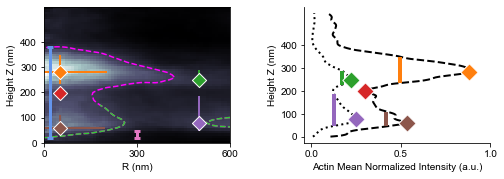

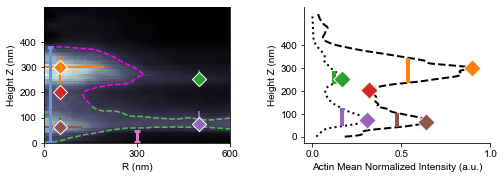

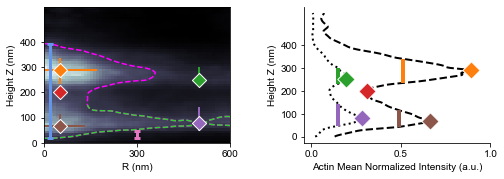

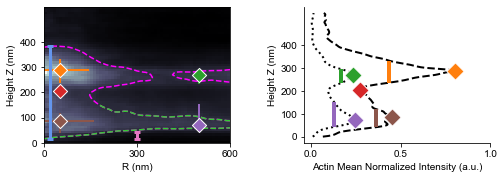

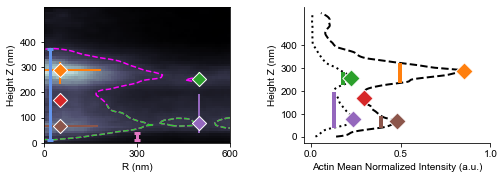

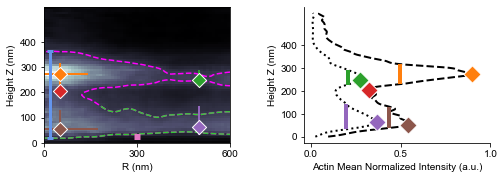

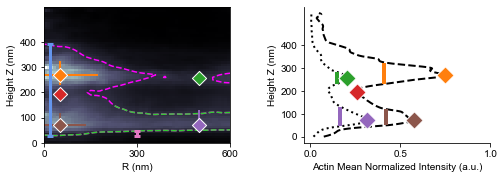

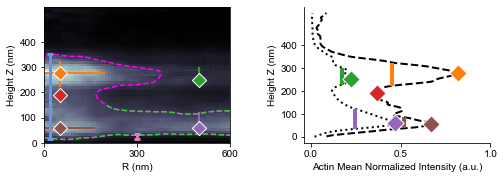

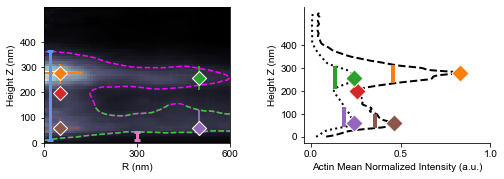

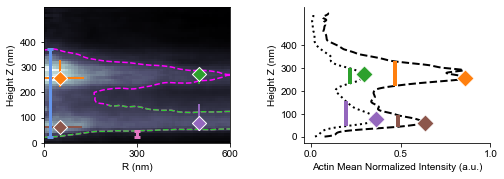

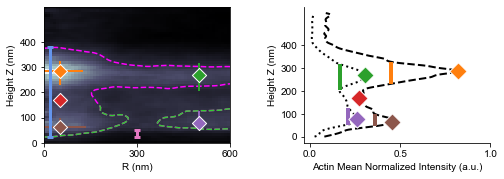

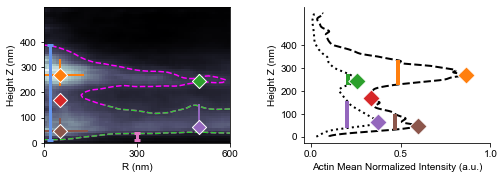

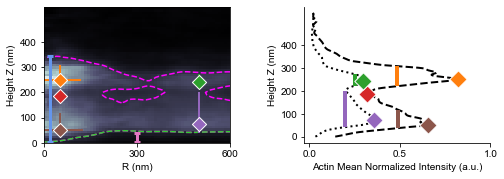

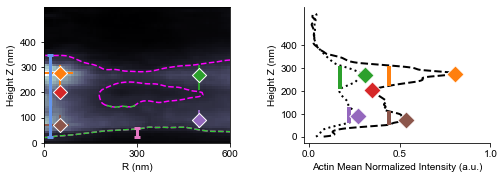

In [51]:
stack_all_rad_scans = np.hstack(all_rad_scans)
from scipy.signal import find_peaks, peak_widths

pod_height = []
protrusion_below_net = []

two_peaks_pod = []
one_peak_pod = []
all_troughs = []

fwhm_upper_core = []
radii_fwhm_upper_core = []
fwhm_lower_core = []
radii_fwhm_lower_core = []

two_peaks_net = []
one_peak_net = []
peaks_net = []

fwhm_upper_net = []
fwhm_lower_net = []

colors = sns.color_palette() #"hls", 7)
colors[0] = 'cornflowerblue'

pods_main = [0,2,10,22,48,50,66]

for pod_i in range(np.shape(stack_all_rad_scans)[1]):
    f, (ax_hm, ax_peak) = plt.subplots(1,2,gridspec_kw={'width_ratios': [.5,.5]},figsize=(8.,2.5))
    ## for supplement
#     f, (ax_hm, ax_peak) = plt.subplots(1,2,gridspec_kw={'width_ratios': [.5,.5]},figsize=(6.,1.5))
#     matplotlib.rcParams.update({'font.size': 12})
    
    average_radial = np.array(stack_all_rad_scans)[:,pod_i,:] 
    average_radial = max_min_scaled(average_radial)

    
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 


    # Get meshgrid for contour
    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(0, 10*(len(average_radial)-1), len(average_radial))
    X, Y = np.meshgrid(x, y)

    im = ax_hm.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)
    CS = ax_hm.contour(X,Y,average_radial_smoothed,levels=np.array([contour_level]), colors='magenta', linestyles='--',linewidth=0.5,zorder=1)
    
    # Get contour segments
    segs = CS.allsegs[0]
    seg_min_y = [np.min(seg.T[1]) if len(seg.T[1]) > 30 else 10e5 for seg in segs]
    seg_max_y = [np.max(seg.T[1]) if len(seg.T[1]) > 30 else 0 for seg in segs]
    
    # Podosome height is the difference between max and min y values of the contour
    pod_height.append(np.max(seg_max_y)-np.min(seg_min_y))

    x_loc = 20
    ax_hm.vlines(x_loc,np.max(seg_max_y),np.min(seg_min_y),color=colors[0],lw=3,zorder=9)
    ax_hm.hlines(np.max(seg_max_y),x_loc-10,x_loc+10,color=colors[0],lw=3,zorder=9)
    ax_hm.hlines(np.min(seg_min_y),x_loc-10,x_loc+10,color=colors[0],lw=3,zorder=9)

    ax_hm.set_yticks([0,100,200,300,400])
    ax_hm.set_ylabel('Height Z (nm)') #''Height Z (nm) ')
    ax_hm.set_xlabel('R (nm)')

    
    # Zoom in an observe contour below 100 nm Z
    average_radial_zoomed = average_radial[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    CS = ax_hm.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5,zorder=2)

    #get quantifications within 100 nm (podosome quantifications)
    average_radial_within = np.mean(average_radial.T[:11],axis=0)
    finterp = scpy.interpolate.interp1d(heights,average_radial_within,kind='cubic')
    h_interp = np.linspace(0,np.max(heights),1000)
    y_interp = finterp(h_interp)
    
    ax_peak.plot(y_interp,h_interp,'--',lw=2,zorder=-1,c='k')
#     plt.title('Mean Actin At R<=100 nm')
    ax_peak.set_ylabel('Height Z (nm)')
    ax_peak.set_xlabel('Actin Mean Normalized Intensity (a.u.)')
    
    peaks, _ = find_peaks(y_interp,prominence = 0.2*np.max(y_interp))
    results_half = np.array(peak_widths(y_interp, peaks, rel_height=0.5))
#     plt.scatter(y_interp[peaks],h_interp[peaks],50,marker='x',color='r')

    for peak in peaks:
        if h_interp[peak] < 200:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[5],zorder=10,edgecolor='w')
            ax_hm.scatter(50,h_interp[peak],100,marker='D',color=colors[5],zorder=10,edgecolor='w')
            
        else:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[1],zorder=10,edgecolor='w')
            ax_hm.scatter(50,h_interp[peak],100,marker='D',color=colors[1],zorder=10,edgecolor='w')
    
    fwhm_hs = results_half[1]
    fwhm_lhs = h_interp[[np.int(val) for val in results_half[2]]]
    fwhm_rhs = h_interp[[np.int(val) for val in results_half[3]]]
    
    trough = []
    troughs, _ = find_peaks(-y_interp,prominence = 0.1*np.max(y_interp))
    
    if len(troughs) ==1:
        all_troughs.append(h_interp[troughs])
        ax_peak.scatter(y_interp[troughs],h_interp[troughs],150,marker='D',color=colors[3],zorder=10,edgecolor='w')
        ax_hm.scatter(50,h_interp[troughs],100,marker='D',color=colors[3],zorder=10,edgecolor='w')
      
        trough = h_interp[troughs[0]]

            
    #get vertical FWHM quantifications for the podosome
    #adjusts fwhm so that it doesn't pass a prominent minima (and go into another peak)
    for j in range(len(fwhm_hs)):
        lhs,rhs = fwhm_lhs[j],fwhm_rhs[j]
        peak_loc = h_interp[int(peaks[j])]
        
        if peak_loc < 175:
            if trough:
                if rhs > trough:
                    rhs = trough
            fwhm = rhs-lhs
            fwhm_lower_core.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs, color=colors[5],lw=4)
            ax_hm.vlines(50,lhs,rhs, color=colors[5],lw=2)
            
             # get FWHM/2 (=Radius) for lower core
            lc_arr = np.mean(average_radial[int(lhs/10):int(rhs/10)],axis=0)
            rs = np.linspace(-max_r, max_r, 2*len(average_radial[0])-1)
            mirror_wnoise = out_in_1d(lc_arr,lc_arr) + np.random.rand(len(rs))*10e-5
            finterp_lc = scpy.interpolate.interp1d(rs,mirror_wnoise,kind='cubic')
            r_interp_lc = np.linspace(-max_r,max_r,1001)
            y_interp_lc = finterp_lc(r_interp_lc)
            peaks_lc, _ = find_peaks(y_interp_lc,prominence = 0.2*np.max(y_interp_lc))
            if np.shape(peaks_lc)[0] >1:
                peaks_lc = [peaks_lc[0]]

            results_half_lc = np.array(peak_widths(y_interp_lc, peaks_lc, rel_height=0.5))

            fwhm_lc_rhs = np.abs(r_interp_lc[[np.int(val) for val in results_half_lc[3]]])

            ax_hm.hlines(peak_loc,0,fwhm_lc_rhs, color=colors[5],lw=2)

            radii_fwhm_lower_core.append(fwhm_lc_rhs[0])
            
            
        else:
            if trough:
                if lhs < trough:
                    lhs = trough
            fwhm = rhs-lhs
            fwhm_upper_core.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs ,color=colors[1],lw=4)
            ax_hm.vlines(50,lhs,rhs, color=colors[1],lw=2)

            # get FWHM/2 (=Radius) for lower core
            uc_arr = np.mean(average_radial[int(lhs/10):int(rhs/10)],axis=0)
            rs = np.linspace(-max_r, max_r, 2*len(average_radial[0])-1)
            #out_in_1d reflects the scan - makes the peak/FWHM finding easier
            mirror_wnoise = out_in_1d(uc_arr,uc_arr) + np.random.rand(len(rs))*10e-5
            finterp_uc = scpy.interpolate.interp1d(rs,mirror_wnoise,kind='cubic')
            r_interp_uc = np.linspace(-max_r,max_r,1001)
            y_interp_uc = finterp_uc(r_interp_uc)
            peaks_uc, _ = find_peaks(y_interp_uc,prominence = 0.2*np.max(y_interp_uc))
            if np.shape(peaks_uc)[0] >1:
                peaks_uc = [peaks_uc[0]]
            results_half_uc = np.array(peak_widths(y_interp_uc, peaks_uc, rel_height=0.5))
            fwhm_uc_rhs = np.abs(r_interp_uc[[np.int(val) for val in results_half_uc[3]]])
            ax_hm.hlines(peak_loc,0,fwhm_uc_rhs, color=colors[1],lw=2)
            radii_fwhm_upper_core.append(fwhm_uc_rhs[0])

    if(len(peaks)==1):
        one_peak_pod.append(h_interp[peaks])
        
    elif(len(peaks)==2):
        two_peaks_pod.append(h_interp[peaks])
        
    peaks_net.append(h_interp[peaks])

    #get quantifications for beyond 400 nm (upper and lower actin network)  
    average_radial_beyond = np.mean(average_radial.T[len(average_radial.T)*2//3:],axis=0)
    finterp = scpy.interpolate.interp1d(heights,average_radial_beyond,kind='cubic')
    h_interp = np.linspace(0,np.max(heights),max_r)
    y_interp = finterp(h_interp)
    
    ax_peak.plot(y_interp,h_interp,':',lw=2,zorder=-1,c='k')
    
    peaks, _ = find_peaks(y_interp,prominence = 0.1*np.max(y_interp))
    results_half = np.array(peak_widths(y_interp, peaks, rel_height=0.5))
#     plt.scatter(y_interp[peaks],h_interp[peaks],50,marker='x',color='r')
    
    for peak in peaks:
        if h_interp[peak] < 175:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[4],zorder=10,edgecolor='w')
            ax_hm.scatter(500,h_interp[peak],100,marker='D',color=colors[4],zorder=10,edgecolor='w')
        else:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[2],zorder=10,edgecolor='w')
            ax_hm.scatter(500,h_interp[peak],100,marker='D',color=colors[2],zorder=10,edgecolor='w')
            
    minima, _ = find_peaks(-y_interp,prominence = 0.1*np.max(y_interp))
    
#     find actual minima value
    if minima:
        minima = h_interp[minima[0]]
            
    fwhm_hs = results_half[1]
    fwhm_lhs = h_interp[[np.int(val) for val in results_half[2]]]
    fwhm_rhs = h_interp[[np.int(val) for val in results_half[3]]]
    

    #get vertical FWHM quantifications for the actin network values
    #adjusts fwhm so that it doesn't pass a prominent minima (and go into another peak)
    for j in range(len(fwhm_hs)):
        lhs,rhs = fwhm_lhs[j],fwhm_rhs[j]
        peak_loc = h_interp[int(peaks[j])]
        
        if peak_loc < 175:
            if minima:
                if rhs > minima:
                    rhs = minima
            fwhm = rhs-lhs
            fwhm_lower_net.append(fwhm)

            protrusion_below_net.append(lhs-np.min(seg_min_y))
            
            ax_hm.vlines(300,lhs,np.min(seg_min_y),color=colors[6],lw=3,zorder=9)
            ax_hm.hlines(lhs,300-10,300+10,color=colors[6],lw=3,zorder=9)
            ax_hm.hlines(np.min(seg_min_y),300-10,300+10,color=colors[6],lw=3,zorder=9)
            
            ax_peak.vlines(fwhm_hs[j],lhs,rhs, color=colors[4],lw=4)
            ax_hm.vlines(500,lhs,rhs, color=colors[4],lw=2)  
        else:
            if minima:
                if lhs < minima:
                    lhs = minima
            fwhm = rhs-lhs
            fwhm_upper_net.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs ,color=colors[2],lw=4)
            ax_hm.vlines(500,lhs,rhs, color=colors[2],lw=2)

    
    if(len(peaks)==1):
        one_peak_net.append(h_interp[peaks])
        
    elif(len(peaks)==2):
        two_peaks_net.append(h_interp[peaks])
        
    custom_lines = [Line2D([0], [0], color='k', lw=2,ls='--'),
                Line2D([0], [0], color='k', lw=2,ls=':')]

    ax=plt.gca()
    ax_peak.spines['right'].set_visible(False)
    ax_peak.spines['top'].set_visible(False)
#     ax_peak.legend(custom_lines, ['Within 100 nm',  'Outside 400 nm'])#,bbox_to_anchor=(1.1, 1.1))
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.35)


    ax_hm.set_xticks([0,300,600])
    ax_hm.set_yticks([0,100,200,300,400])
    
    ax_peak.set_xticks([0,0.5,1])
    ax_peak.set_yticks([0,100,200,300,400])
    
    
    plt.subplots_adjust(wspace=0.4)
    ax_hm.set_aspect('auto')
    
#     if pod_i in pods_main or pod_i==2:
#         plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure5_PodosomeQuantifications/IndividualPlots/IndQuantPeakFWHMPod%i.pdf"%pod_i,transparent=True,dpi=300,bbox_inches='tight')


plt.show()

